# Forecasting U.S. Stock Indices

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/FinanceOps) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmlHaWuVxIA0pKL1yjryR0Z)

## Introduction

In a [previous paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/02_Comparing_Stock_Indices.ipynb) we compared the historical returns of different stock indices for USA. We also discussed the desirability of being able to forecast future returns from e.g. the P/Sales or P/Book ratios, which will be done in this paper using the mathematical model from [another previous paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/01C_Theory_of_Long-Term_Stock_Forecasting.ipynb). This allows us to compare the forecasted returns for the major U.S. stock indices, to assess which might be the best long-term investment given their current P/Sales ratios. We will study the S&P 500 (Large-Cap), S&P 400 (Mid-Cap), S&P 600 (Small-Cap), and NASDAQ 100 (mainly technology) stock indices.

The main ideas will be described again in this paper so it can hopefully be read by itself. For detailed explanations of the mathematics you should read the previous papers.

## Python Imports

This Jupyter Notebook is implemented in Python v. 3.6 and requires various packages for numerical computations and plotting. See the installation instructions in the README-file.

In [1]:
%matplotlib inline

In [2]:
# Imports from Python packages.
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import ttest_rel, ttest_ind
import pandas as pd
import numpy as np
import os

In [3]:
# Imports from FinanceOps.
from data_keys import *
from data import load_index_data, load_stock_data
from returns import reinvestment_growth, prepare_ann_returns, prepare_mean_ann_returns

## Load Data

We now load all the financial data we will be using.

In [4]:
# Define the ticker-names for the stock-indices we consider.
ticker_SP500 = "S&P 500"
ticker_SP400 = "S&P 400"
ticker_SP600 = "S&P 600"

In [5]:
# Load the financial data for the stock-indices.
df_SP500 = load_index_data(ticker=ticker_SP500)
df_SP400 = load_index_data(ticker=ticker_SP400, book_value=False)
df_SP600 = load_index_data(ticker=ticker_SP600, book_value=False)

### Load Data for NASDAQ

For the NASDAQ index, I was unable to obtain the original fundamental data such as Sales Per Share, so we will instead use data for the Exchange Traded Fund (ETF) with the ticker symbol QQQ which tracks the NASDAQ index. The fundamental data was obtained from the Morningstar Direct database. We need the Sales Per Share data but the database only contains the P/Sales data, so the Sales Per Share has been estimated using this formula:

$$
    Sales\ Per\ Share_t = \frac{Share\ Price_t}{P/Sales_t}
$$

In [6]:
# Load NASDAQ data for the ETF with ticker QQQ.
ticker_QQQ = "QQQ"
df_QQQ = load_stock_data(ticker=ticker_QQQ, earnings=False, book_value=False)

# Estimate Dividend Yield from diff. btw. Total Return and Share-Price.
df_QQQ[DIVIDEND_YIELD] = reinvestment_growth(df_QQQ, smooth=True)

## Mathematical Model

Let us define the Total Return of a stock at time-step $t$ as the number of shares which may grow from reinvestment of dividends (taxes are ignored), multiplied by the share-price:

$$
Total\ Return_t = Shares_t \cdot Share\ Price_t
$$

The annualized return between the start-date $t$ and the end-date $t+Years$ is defined as:

$$
Ann\ Return_t
= \left( \frac{Total\ Return_{t+Years}}{Total\ Return_t} \right) ^ {1/Years} - 1
$$

From this definition, the [previous paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/01C_Theory_of_Long-Term_Stock_Forecasting.ipynb) derived two formulas for the mean and standard deviation of the annualized return given the P/Sales ratio at time-step $t$:

$$
E[Ann\ Return_t] = \frac{a}{P/Sales_t ^ {1/Years}} - 1
$$

$$
Std[Ann\ Return_t] = \frac{b}{P/Sales_t ^ {1/Years}}
$$

where the parameters $a$ and $b$ can be estimated from three factors: (1) The growth in the number of shares from reinvestment of dividends, (2) the growth in Sales Per Share, and (3) the change in the P/Sales valuation ratio. The parameters are estimated as:

$$
a \simeq E[Dividend\ Yield + 1]
\cdot E[Sales\ Per\ Share\ Growth + 1]
\cdot E[ P/Sales ^ {1/Years} ]
$$

$$
b \simeq Std \left[ (Dividend\ Yield + 1) \cdot (Sales\ Per\ Share\ Growth + 1) \cdot P/Sales ^ {1/Years} \right]
$$

Forecasting the future return on a stock can therefore be split into forecasting these three factors. We can use historical values for the dividend yield, sales growth, and P/Sales ratios, or we can use other numbers if we think the future will be different from the past.

## Implementation

This class implements the forecasting model.

In [7]:
class ForecastModel:
    """
    Mathematical model used to forecast long-term stock returns.
    """

    def __init__(self, dividend_yield, sales_growth,
                 psales, years):
        """
        Create a new model and fit it with the given data.
        
        :param dividend_yield: Array with dividend yields.
        :param sales_growth: Array with one-year sales growth.
        :param psales: Array with P/Sales ratios.
        :param years: Number of years.
        """
        
        # Copy args to self.
        # Note the +1 for dividend yield and sales-growth
        # so we don't have to do it several times below.
        self.dividend_yield = np.array(dividend_yield) + 1
        self.sales_growth = np.array(sales_growth) + 1
        self.psales = psales
        self.years = years
        
        # Calculate the `a` parameter for the mean ann.return.
        self.a = self.mean_parameter()

        # Calculate the `b` parameter for the std.dev. ann.return.
        self.b = self.std_parameter()

    def forecast(self, psales_t):
        """
        Use the fitted model to forecast the mean and std.dev.
        for the future stock returns.
        
        :param psales_t: Array with different P/Sales ratios at buy-time.
        :return: Two arrays with mean and std.ann. for the ann. returns
                 for each of the psales_t values.
        """

        # Annualized psales_t which is used in both formulas.
        psales_t_ann = psales_t ** (1/self.years)

        # Forecast the mean and std.dev. for the ann. returns
        # for the different choices of P/Sales ratios at the
        # time of buying the stock.
        mean = self.a / psales_t_ann - 1.0
        std = self.b / psales_t_ann

        return mean, std

    def mean_parameter(self):
        """
        Estimate the parameter `a` used in the formula for the
        mean annualized return, given arrays with distributions
        for the dividend yield, sales-growth and P/Sales.

        :return: The parameter `a` for the mean return formula.
        """

        # We assume dividend_yield and sales_growth is already +1.
        a = np.mean(self.dividend_yield) \
          * np.mean(self.sales_growth) \
          * np.mean(self.psales ** (1/self.years))

        return a

    def std_parameter(self, num_samples=10000):
        """
        Estimate the parameter `b` used in the formula for the
        std.dev. annualized return, given arrays with distributions
        for the dividend yield, sales-growth and P/Sales.

        This is estimated using Monte Carlo simulation / resampling
        of the given data, which is assumed to be independent of
        each other and over time.

        :param num_samples: Number of Monte Carlo samples.
        :return: The parameter `b` for the std.dev. return formula.
        """

        # We will do a Monte Carlo simulation / resampling
        # from the supplied arrays of data. For each year
        # we take e.g. 10k random samples and then we
        # calculate the annualized growth-rates. This gives
        # us different values for dividend yields and sales-growth
        # for each year, instead of just taking one random
        # number and using that for all the years.

        # Shape of arrays to sample.
        shape = (num_samples, self.years)
        num_samples_total = np.prod(shape)

        # Sample the dividend yield. We assume it is already +1.
        dividend_yield_sample = np.random.choice(self.dividend_yield, size=shape)
        # Compound the growth through the years.
        dividend_yield_sample = np.prod(dividend_yield_sample, axis=1)

        # Sample the sales-growth. We assume it is already +1.
        sales_growth_sample = np.random.choice(self.sales_growth, size=shape)
        # Compound the growth through the years.
        sales_growth_sample = np.prod(sales_growth_sample, axis=1)

        # Sample the P/Sales ratio at the time of selling.
        psales_sample = np.random.choice(self.psales, size=num_samples)

        # Combine the three samples.
        combined_sample = dividend_yield_sample * sales_growth_sample * psales_sample

        # Calculate the `b` parameter.
        b = np.std(combined_sample ** (1/self.years))

        return b
    
    def _ttest(self, err_forecast, err_baseline):
        """
        Perform a t-test on the residual errors of the
        forecasting model and the baseline to assess whether
        their means are equal.
        
        When the resulting p_value is close to zero, the means
        are unlikely to be equal.
        
        :param err_forecast:
            Residual errors for the forecasting model.

        :param err_baseline:
            Residual errors for the baseline.

        :return:
            p_value
        """
        
        if True:
            # Paired t-test.
            t_value, p_value = ttest_rel(a=err_forecast, b=err_baseline)
        else:
            # Un-paired / independent t-test.
            t_value, p_value = ttest_ind(a=err_forecast, b=err_baseline, equal_var=False)

        return p_value

    def MAE(self, psales_t, ann_rets):
        """
        Calculates the Mean Absolute Error (MAE) between the
        model's forecasted mean and the observed annualized returns.
        
        Also calculates the MAE between the baseline and the
        observed annualized returns.
        
        Also calculates the p-value that the forecasted and
        baseline MAE values are equal.
        
        :param psales_t:
            Array with different P/Sales ratios at buy-time.
            
        :param ann_rets:
            Array with the corresponding annualized returns.

        :return:
            mae_forecast: MAE between model's forecast and actual returns.
            mae_baseline: MAE between baseline and actual returns.
            p_value: p-value whether the two MAE values are equal.
        """

        # Forecast the mean and std.dev. for the stock returns,
        # from the historical P/Sales ratios.
        mean_forecast, std_forecast = self.forecast(psales_t=psales_t)

        # Errors between observed data and forecasting model.
        err_forecast = np.abs(ann_rets - mean_forecast)
        
        # Baseline errors between observed data and its mean.
        err_baseline = np.abs(ann_rets - np.mean(ann_rets))
        
        # Mean Absolute Errors (MAE).
        mae_forecast = np.mean(err_forecast)
        mae_baseline = np.mean(err_baseline)
        
        # Hypothesis test whether the two MAE values are equal.
        p_value = self._ttest(err_forecast=err_forecast,
                              err_baseline=err_baseline)

        return mae_forecast, mae_baseline, p_value
    
    def R_squared(self, psales_t, ann_rets):
        """
        Calculate the Coefficient of Determination R^2 for
        measuring the Goodness of Fit between the forecasted
        mean and the observed annualized returns.

        An R^2 value of one means there is a perfect fit and
        the forecasting model explains all of the variance
        in the data. An R^2 value of zero means the forecasting
        model does not explain any of the variance in the data.
        
        Note that because the forecasting model is non-linear,
        the R^2 can become negative if the model fits poorly
        on data with a large variance.

        :param psales_t:
            Array with different P/Sales ratios at buy-time.
            
        :param ann_rets:
            Array with the corresponding annualized returns.

        :return:
            R^2 value.
        """

        # Forecast the mean and std.dev. for the stock returns,
        # from the historical P/Sales ratios.
        mean_forecast, std_forecast = self.forecast(psales_t=psales_t)

        # Errors between observed data and forecasting model.
        err_forecast = (ann_rets - mean_forecast) ** 2
        
        # Baseline errors between observed data and its mean.
        err_baseline = (ann_rets - np.mean(ann_rets)) ** 2
        
        # Sum of Squared Errors (SSE) for the forecasting model.
        sse = np.sum(err_forecast)
        
        # Sum of Squared Errors (SST) for the baseline.
        sst = np.sum(err_baseline)

        # The R^2 value.
        R_squared = 1.0 - sse / sst
        
        return R_squared

## Print Statistics

This helper-function prints the various statistics for a forecasting model.

In [8]:
def print_statistics(model, psales_t, ann_rets):
    """
    Calculate and print the Goodness of Fit statistics
    for a model's forecast compared to the baseline.

    The p-value results from a paired t-test whether
    the values are equal. A p-value close to zero means
    that the values are unlikely to be equal.

    :param model:
        Instance of the ForecastModel class.

    :param psales_t:
        Array with different P/Sales ratios at buy-time.

    :param ann_rets:
        Array with the corresponding annualized returns.
    """
    
    # Print header.
    print("\tForecast\tBaseline\tp-value")
    print("=================================================")

    # Mean Absolute Error (MAE).
    mae_forecast, mae_baseline, p_value = model.MAE(psales_t=psales_t,
                                                    ann_rets=ann_rets)
    msg = "MAE:\t{0:.1%}\t\t{1:.1%}\t\t{2:.2e}"
    msg = msg.format(mae_forecast, mae_baseline, p_value)
    print(msg)

    # R^2.
    R_squared = model.R_squared(psales_t=psales_t,
                                ann_rets=ann_rets)
    msg = "R^2:\t{0:.2f}"
    msg = msg.format(R_squared)
    print(msg)

## Plotting Functions

This is the helper-function for plotting the historical annualized returns and overlay them with the mean and standard deviation of the forecasting model.

In [9]:
def plot_ann_returns(ticker, df, years, years_range=0,
                     dividend_yield=None, sales_growth=None,
                     psales=None,
                     psales_min=None, psales_max=None):
    """
    Create a plot with the actual historical returns showing
    the P/Sales ratios vs. future Annualized Returns. Overlay
    this plot with the estimated mean and std.dev. from the
    mathematical forecasting model we have derived above.
    
    The optional params are taken from the DataFrame `df`
    if not supplied. This allows you to override some or
    all of the data used in the forecasting model e.g.
    to change assumptions about future sales-growth.
    
    :param ticker: String with ticker for the stock or index.
    :param df: Pandas DataFrame.
    :param years: Number of investment years.
    :param years_range:
        If > 0 then plot the mean ann. returns between
        years - years_range and years + years_range.
    :param dividend_yield: (Optional) Array with dividend yields.
    :param sales_growth: (Optional) Array with one-year sales growth.
    :param psales: (Optional) Array with P/Sales ratios.
    :param psales_min: (Optional) Min P/Sales for plotting curves.
    :param psales_max: (Optional) Max P/Sales for plotting curves.
    :return: None.
    """
    
    # Create a single plot.
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(211)

    # Select only the data we need.
    df2 = df[[TOTAL_RETURN, DIVIDEND_YIELD, SALES_GROWTH, PSALES]]

    # Remove rows for which there is missing data.
    df2 = df2.dropna()
    
    # Part of the title for the data's date-range.
    start_date, end_date = df2.index[[0, -1]]
    title_dates = "({0}-{1})".format(start_date.year, end_date.year)

    # Get Dividend Yield if none provided.
    if dividend_yield is None:
        dividend_yield = df2[DIVIDEND_YIELD]

    # Get Sales Growth if none provided.
    if sales_growth is None:
        sales_growth = df2[SALES_GROWTH]

    # Get P/Sales if none provided.
    if psales is None:
        psales = df2[PSALES]

    # Get min P/Sales for plotting if none provided.
    if psales_min is None:
        psales_min = np.min(psales)
    
    # Get max P/Sales for plotting if none provided.
    if psales_max is None:
        psales_max = np.max(psales)
        
    # Create the forecasting model and fit it to the data.
    model = ForecastModel(dividend_yield=dividend_yield,
                          sales_growth=sales_growth,
                          psales=psales, years=years)
    
    # Evenly spaced P/Sales ratios between historic min and max.
    psales_t = np.linspace(start=psales_min, stop=psales_max, num=100)

    # Use the model to forecast the mean and std ann.returns.
    mean, std = model.forecast(psales_t=psales_t)

    # Plot the mean ann.return.
    ax.plot(psales_t, mean, color="black", label="Forecast Mean")
    
    # Plot one standard deviation.
    color = "green"
    alpha = 0.3
    # Plot lines below and above mean.
    ax.plot(psales_t, mean-std, color=color,
            label="Forecast Mean $\pm$ 1 Std.Dev.")
    ax.plot(psales_t, mean+std, color=color)
    # Fill the areas.
    ax.fill_between(psales_t, mean+std, mean-std,
                    color=color, edgecolor=color, alpha=alpha)
    
    # Plot two standard deviations.
    color = "red"
    alpha = 0.1
    # Plot lines below and above mean.
    ax.plot(psales_t, mean-2*std, color=color,
            label="Forecast Mean $\pm$ 2 Std.Dev.")
    ax.plot(psales_t, mean+2*std, color=color) 
    # Fill the areas.
    ax.fill_between(psales_t, mean-std, mean-2*std,
                    color=color, edgecolor=color, alpha=alpha)
    ax.fill_between(psales_t, mean+std, mean+2*std,
                    color=color, edgecolor=color, alpha=alpha)

    # Get the actual ann. returns from the historic data.
    if years_range > 0:
        # Use the mean. ann. returns between [min_years, max_years].
        min_years = years - years_range
        if min_years < 1:
            min_years = 1
        max_years = years + years_range

        # Get the mean ann.returns from the historic data.
        x, y = prepare_mean_ann_returns(df=df2,
                                        min_years=min_years,
                                        max_years=max_years,
                                        key=PSALES)

        # First part of the plot-title.
        title1 = "[{0}] {1}-{2} Year Mean Ann. Return {3}".format(ticker, min_years, max_years, title_dates)
        
        # Label for the scatter-plot of actual returns.
        label_returns = "Actual Returns (Mean)"
    else:
        # Get the ann.returns from the historic data.
        x, y = prepare_ann_returns(df=df2, years=years, key=PSALES)
    
        # First part of the plot-title.
        title1 = "[{0}] {1}-Year Ann. Return {2}".format(ticker, years, title_dates)
        
        # Label for the scatter-plot of actual returns.
        label_returns = "Actual Returns"

    # Scatter-plot with the actual P/Sales vs. Ann.Returns.
    ax.scatter(x, y, label=label_returns)

    # Plot baseline mean as horizontal dashed line.
    ax.axhline(y=np.mean(y), color="black", linestyle="--",
               label="Baseline")

    # Show the labels for what we have just plotted.
    ax.legend()

    # Create plot-title.
    # Second part of the title. Formula for mean ann. return.
    msg = "E[Ann Return] = {0:.2f} / (P/Sales ^ (1/{1})) - 1"
    title2 = msg.format(model.a, years)
    # Third part of the title. Formula for std.dev. ann. return.
    msg = "Std[Ann Return] = {0:.3f} / (P/Sales ^ (1/{1}))"
    title3 = msg.format(model.b, years)
    # Combine and set the plot-title.
    title = "\n".join([title1, title2, title3])
    ax.set_title(title)

    # Convert y-ticks to percentages.
    formatter = FuncFormatter(lambda y, _: '{:.0%}'.format(y))
    ax.yaxis.set_major_formatter(formatter)

    # Set axes labels.
    ax.set_xlabel("P/Sales")
    ax.set_ylabel("Annualized Return")

    # Show grid.
    ax.grid()
    
    # Show the plot.
    plt.show()
    
    # Print the Goodness of Fit statistics.
    print_statistics(model=model, psales_t=x, ann_rets=y)

This is a helper-function to plot a comparison of the Share-Price and Total Return.

In [10]:
def plot_price_total_return(df):
    """
    Plot Share-Price and Total Return normalized to start at 1.
    """
    
    df2 = df[[TOTAL_RETURN, SHARE_PRICE]].dropna()
    df2 /= df2.values[0]
    df2.plot(grid=True)

## S&P 500 (Large-Cap)

The S&P 500 is a stock-market index consisting of the stocks of 500 of the largest companies in USA. The S&P 500 covers about 80% of the whole U.S. stock-market in terms of size so it is useful as a gauge for the entire U.S. stock-market (see [Fact Sheet](https://us.spindices.com/indices/equity/sp-500)).

### S&P 500 - Price and Total Return

The following plot compares the share-price of the S&P 500 with its Total Return between 1989 and 2017. The Total Return is calculated by reinvesting the dividends back into the S&P 500 while ignoring taxes.

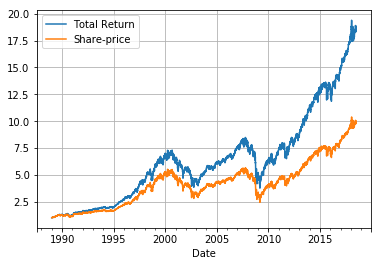

In [11]:
plot_price_total_return(df=df_SP500["1989":])

### S&P 500 - P/Sales

When looking at the above plots for the Share-Price and Total Return of the S&P 500, it is clearly only possible in hindsigt to tell whether a given value was high or low.

We will use the P/Sales ratio as the predictor variable for assessing whether the S&P 500 is priced cheaply or expensively. Further below, we will show how the P/Sales ratio has historically been related to the future returns, and how this fits the forecasting model. 

The following plot and statistics show that the P/Sales ratio varied roughly between 0.6 and 2.2 between 1989 and 2017, with a mean around 1.35.

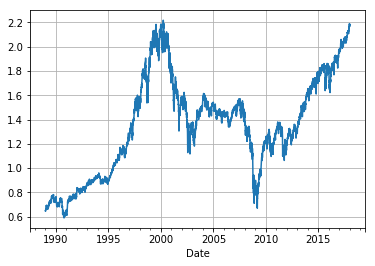

In [12]:
df_SP500[PSALES].plot(grid=True)

In [13]:
df_SP500[PSALES].describe()

count    10591.000000
mean         1.355346
std          0.403827
min          0.590104
25%          1.009636
50%          1.378226
75%          1.618272
max          2.218035
Name: P/Sales, dtype: float64

### S&P 500 - Sales Growth

An important factor of the forecasting model is the growth in sales per share. The following plot and statistics show that the S&P 500 has had somewhat cyclical sales growth between 1989 and 2017, with the mean being around 3.7% and the extremes being -16.5% and 12.6%.

The somewhat cyclical and mean-reverting tendency of the sales growth is important when fitting the forecasting model to historical data, because the model assumes that the mean sales growth is somewhat similar over longer time-periods of e.g. 5-10 years.

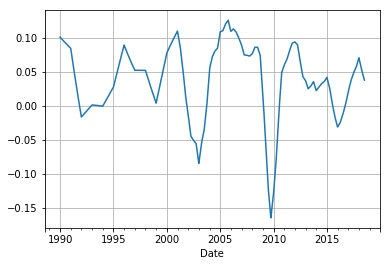

In [14]:
df_SP500[SALES_GROWTH].plot(grid=True)

In [15]:
df_SP500[SALES_GROWTH].describe()

count    10415.000000
mean         0.037141
std          0.053362
min         -0.164586
25%          0.004295
50%          0.043822
75%          0.078067
max          0.125595
Name: Sales Growth, dtype: float64

### S&P 500 - Dividend Yield

The following plot and statistics show the historical dividend yield for the S&P 500 between 1989 and 2017. The mean dividend yield ranged between 1% and 4% with a mean about 2.1%.

The data-set actually contains the dividend yield for the S&P 500 from 1950, but it is important to use matching data periods for the historical P/Sales ratios, sales growth, and dividend yields, which we only have from 1989 for the S&P 500.

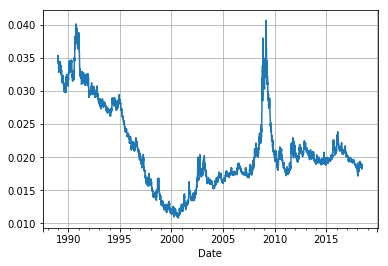

In [16]:
df_SP500[DIVIDEND_YIELD]["1989":].plot(grid=True)

In [17]:
df_SP500[DIVIDEND_YIELD]["1989":].describe()

count    10772.000000
mean         0.021157
std          0.006215
min          0.010819
25%          0.017290
50%          0.019661
75%          0.024518
max          0.040702
Name: Dividend Yield, dtype: float64

### S&P 500 - 1 Year Returns

We now use the forecasting model on the historical data for the S&P 500 between 1989 and 2017. The plot shows the actual one-year returns of the S&P 500 as blue dots. The forecasted mean return is the black solid line. The green area is one forecasted standard deviation around the mean, and the red area is two standard deviations. The dashed black line is the baseline used for comparison and it is just the mean annualized return for the historical data.

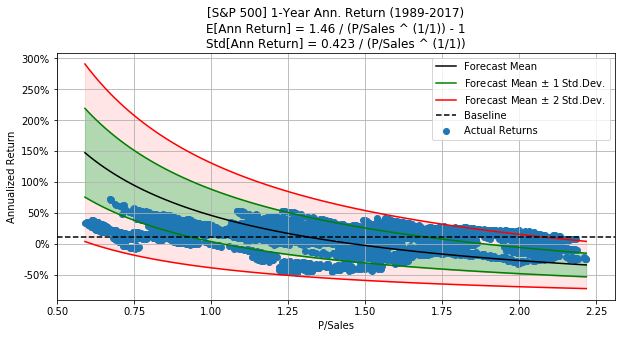

	Forecast	Baseline	p-value
MAE:	28.5%		12.2%		0.00e+00
R^2:	-4.08


In [18]:
plot_ann_returns(years=1, ticker=ticker_SP500, df=df_SP500)

The statistics printed below the plot show that the forecasting model fits the historical data much worse than the baseline average. The Mean Absolute Error (MAE) shows that on average, the absolute error of the forecasting model is 28.5% while it is only 12.2% for the baseline. The p-value is practically zero which means this difference did not happen by random chance. We can therefore conclude, that the forecasting model fits the historical data much worse than the average return, for 1-year investment periods of the S&P 500.

Also note that the $R^2$ is negative because the variance is high for the data and the non-linear forecasting model fits the data poorly.

See the [previous paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/01D_Testing_the_Stock_Forecasting_Model.ipynb) for a more detailed explanation of these statistical measures.

### S&P 500 - 4 Year Returns

For 2 and 3 year periods, the forecasting model also fits the data worse than the average annualized return, so those plots have been omitted.

The following plot shows the annualized return for all 4-year periods of the S&P 500, along with the forecasted mean and standard deviation.

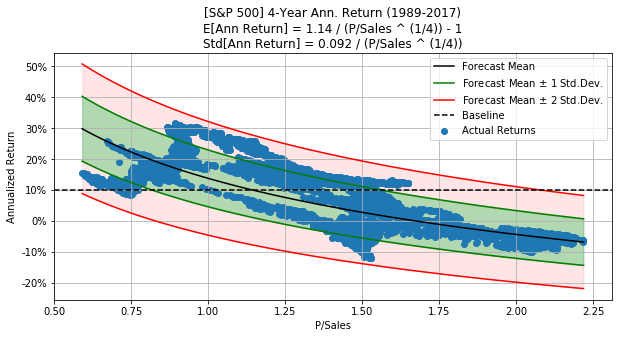

	Forecast	Baseline	p-value
MAE:	6.5%		8.5%		2.11e-164
R^2:	0.41


In [19]:
plot_ann_returns(years=4, ticker=ticker_SP500, df=df_SP500)

The above plot suggests that the forecasting model is a better fit than the baseline, but we would like to quantify exactly how much better, which is shown by the above statistics. The MAE is 6.5% for the forecasting model while it is 8.5% for the baseline. So the forecasting model has a better fit with the absolute error being about 2 percentage points on average. The p-value is practically zero, which means that it is extremely unlikely this happened by random chance. However, the $R^2$ is 0.41 which means that most of the variance in the data is still not explained by the forecasting model.

### S&P 500 - 10 Year Returns

This plot shows the actual returns of the S&P 500 for all 10-year investment periods between 1989 and 2017, which are almost all within one standard deviation of the forecasted mean, so the forecasting model fits the historical data quite well. The $R^2$ value is 0.75 which means that a lot of the data's variance is explained by the forecasting model.

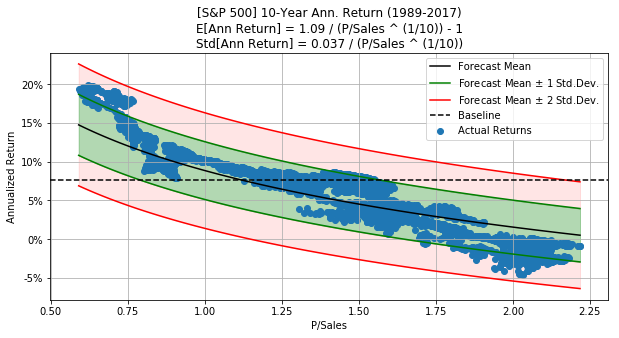

	Forecast	Baseline	p-value
MAE:	2.1%		3.5%		1.10e-277
R^2:	0.75


In [20]:
plot_ann_returns(years=10, ticker=ticker_SP500, df=df_SP500)

### S&P 500 - 6 to 10 Year Returns

The above plot has some irregularity in the blue dots which show the actual 10-year historical returns for the S&P 500. This is due to stock-market bubbles and crashes and the use of a fixed-length 10-year investment period, so at the end of a 10-year period the S&P 500 could be at the peak of a bubble, or at the bottom of a crash.

A simple solution is to let each blue dot represent an average annualized return for investment periods between e.g. 6 and 10 years, which smoothens the effect of daily noise and stock-market bubbles and crashes. This was originally proposed in a [previous paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/01B_Better_Long-Term_Stock_Forecasts.ipynb) and is shown in the following plot. This has a slightly better fit with $R^2 = 0.83$.

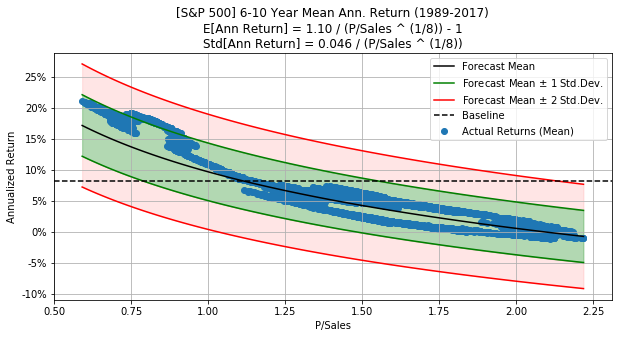

	Forecast	Baseline	p-value
MAE:	2.0%		5.1%		0.00e+00
R^2:	0.83


In [21]:
plot_ann_returns(years=8, years_range=2,
                 ticker=ticker_SP500, df=df_SP500)

### S&P 500 - 3 to 7 Year Returns

This plot shows the historical returns of the S&P 500 averaged for 3-7 year investment periods, which will be used for comparison to the other stock indices. The forecasting model has a decent fit to the historical data with $R^2 = 0.68$.

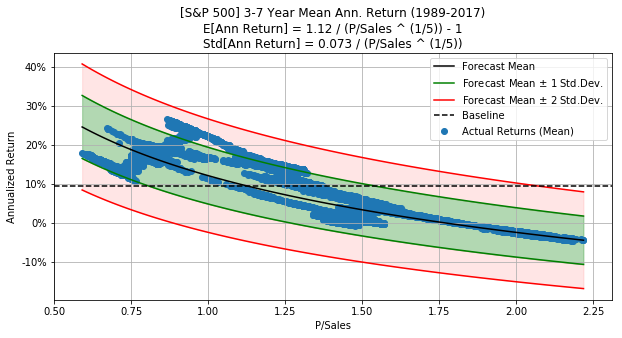

	Forecast	Baseline	p-value
MAE:	3.8%		7.7%		0.00e+00
R^2:	0.68


In [22]:
plot_ann_returns(years=5, years_range=2,
                 ticker=ticker_SP500, df=df_SP500)

## S&P 400 (Mid-Cap)

The S&P 400 stock-market index consists of 400 mid-sized companies in USA, with market-capitalization between USD 1.6-6.8 billion (see the [Fact Sheet](https://us.spindices.com/indices/equity/sp-400)).

### S&P 400 - Price and Total Return

The following plot compares the share-price and Total Return for the S&P 400 between 1995 and 2017.

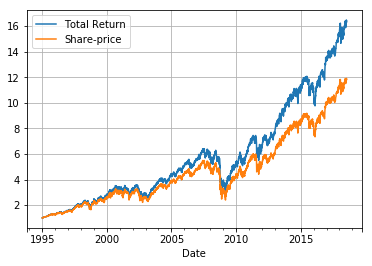

In [23]:
plot_price_total_return(df=df_SP400["1995":])

### S&P 400 - P/Sales

The following plot and statistics show the historical P/Sales ratios for the S&P 400 between 1995 and 2017. The P/Sales ratio was between 0.5 and 1.4 with a mean about 1.1.

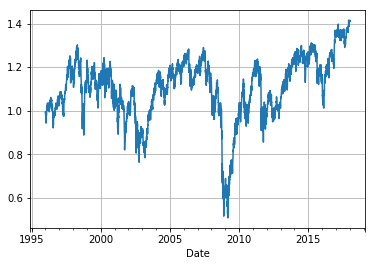

In [24]:
df_SP400[PSALES].plot(grid=True)

In [25]:
df_SP400[PSALES].describe()

count    8037.000000
mean        1.103492
std         0.146182
min         0.508140
25%         1.020054
50%         1.123266
75%         1.201071
max         1.415186
Name: P/Sales, dtype: float64

### S&P 400 - Sales Growth

The following plot and statistics show the historical annual growth in Sales Per Share for the S&P 400, which was between -28% and +10% with a mean of about 8.7%.

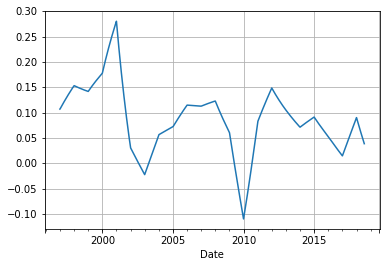

In [26]:
df_SP400[SALES_GROWTH].plot(grid=True)

In [27]:
df_SP400[SALES_GROWTH].describe()

count    7873.000000
mean        0.086952
std         0.066265
min        -0.109900
25%         0.050749
50%         0.086885
75%         0.121823
max         0.280169
Name: Sales Growth, dtype: float64

### S&P 400 - Dividend Yield

The following plot shows the historical dividend yield for the S&P 400 between 1995 and 2018, which ranged between 1% and 2.8% with a mean of about 1.3%.

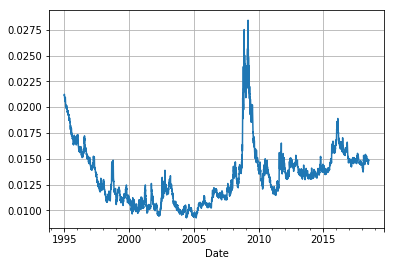

In [28]:
df_SP400[DIVIDEND_YIELD]["1995":].plot(grid=True)

In [29]:
df_SP400[DIVIDEND_YIELD]["1995":].describe()

count    8582.000000
mean        0.013293
std         0.002787
min         0.009265
25%         0.011115
50%         0.013160
75%         0.014702
max         0.028419
Name: Dividend Yield, dtype: float64

### S&P 400 - 1 Year Returns

The following plot shows the actual historical 1-year returns of the S&P 400 as blue dots. The solid black line shows the model's forecasted mean, which has a very poor fit to the historical data.

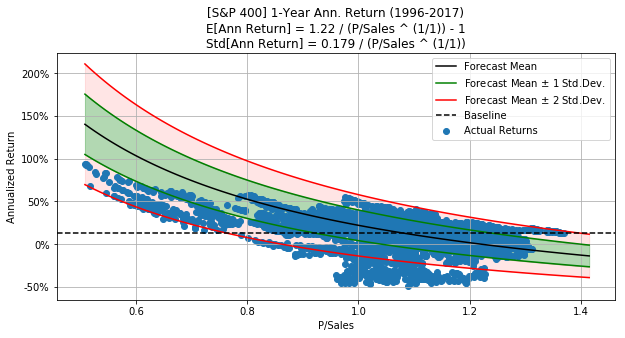

	Forecast	Baseline	p-value
MAE:	14.6%		13.6%		1.19e-15
R^2:	-0.12


In [30]:
plot_ann_returns(years=1, ticker=ticker_SP400, df=df_SP400)

### S&P 400 - 3 Year Returns

The following plot shows the historical 3-year returns of the S&P 400, which starts to fit the forecasting model, but $R^2 = 0.32$ so most of the data's variance is still unexplained.

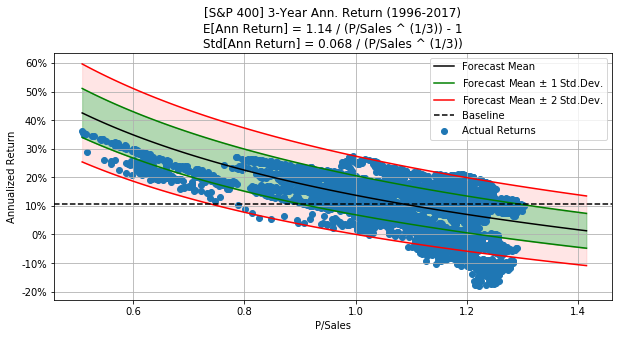

	Forecast	Baseline	p-value
MAE:	5.9%		6.8%		6.50e-83
R^2:	0.32


In [31]:
plot_ann_returns(years=3, ticker=ticker_SP400, df=df_SP400)

### S&P 400 - 5 Year Returns

The following plot shows the historical 5-year returns of the S&P 400. It fits the forecasting model quite well with exception of a cluster of outliers with P/Sales ratios around 1.1. This is probably the 5-year period between 2004 and 2009, which ended in the financial crisis and stock-market crash.

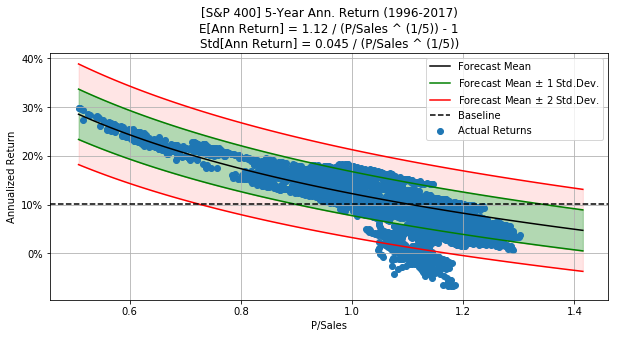

	Forecast	Baseline	p-value
MAE:	2.9%		4.6%		0.00e+00
R^2:	0.56


In [32]:
plot_ann_returns(years=5, ticker=ticker_SP400, df=df_SP400)

### S&P 400 - 3 to 7 Year Returns

We can again smoothen the effect of stock-market bubbles and crashes by considering the mean annualized return for e.g. 3-7 year investment periods. This is shown in the following plot which then fits the forecasting model fairly well with $R^2 = 0.60$.

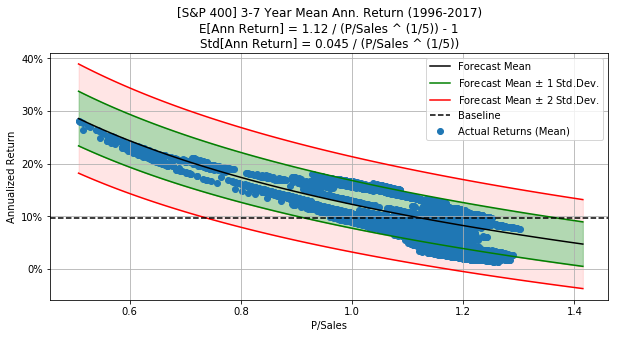

	Forecast	Baseline	p-value
MAE:	2.7%		3.9%		1.92e-185
R^2:	0.60


In [33]:
plot_ann_returns(years=5, years_range=2,
                 ticker=ticker_SP400, df=df_SP400)

### S&P 400 - 10 Year Returns

The following plot shows the S&P 400 for 10-year investment periods, which does not fit the forecasting model very well. The reason is unclear and would require more research.

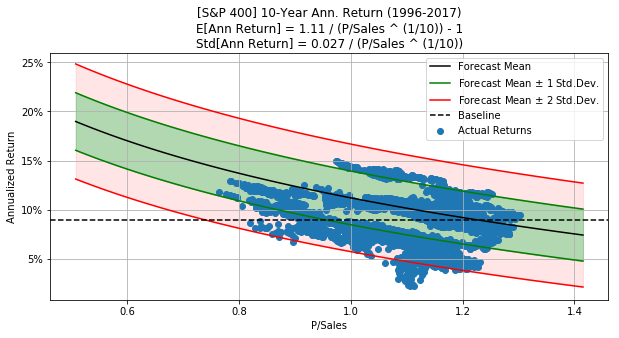

	Forecast	Baseline	p-value
MAE:	2.0%		1.8%		1.05e-16
R^2:	-0.26


In [34]:
plot_ann_returns(years=10, ticker=ticker_SP400, df=df_SP400)

## S&P 600 (Small-Cap)

The S&P 600 stock-market index consists of 600 small-sized companies in the USA, with market-capitalization between USD 0.5-2 billion (see the [Fact Sheet](https://us.spindices.com/indices/equity/sp-600)).


### S&P 600 - Price and Total Return

The following plot compares the share-price and Total Return for the S&P 600 between 1995 and 2017.

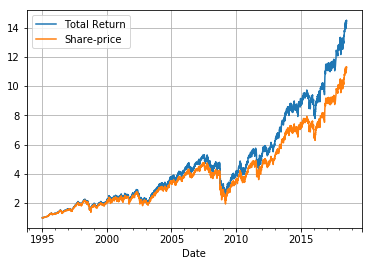

In [35]:
plot_price_total_return(df=df_SP600["1995":])

### S&P 600 - P/Sales

The following plot and statistics show the historical P/Sales ratios for the S&P 600 between 1995 and 2017. The P/Sales ratio was between 0.4 and 1.25 with a mean about 0.9.

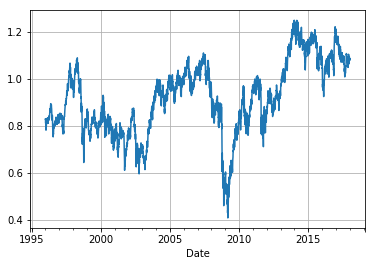

In [36]:
df_SP600[PSALES].plot(grid=True)

In [37]:
df_SP600[PSALES].describe()

count    8037.000000
mean        0.918666
std         0.154023
min         0.409077
25%         0.809512
50%         0.920284
75%         1.034259
max         1.248116
Name: P/Sales, dtype: float64

### S&P 600 - Sales Growth

The following plot and statistics show the historical annual growth in Sales Per Share for the S&P 600, which was between -13% and +23% with a mean of about 8.3%.

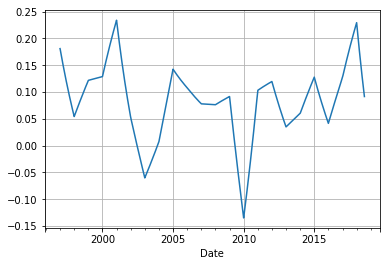

In [38]:
df_SP600[SALES_GROWTH].plot(grid=True)

In [39]:
df_SP600[SALES_GROWTH].describe()

count    7873.000000
mean        0.082902
std         0.066896
min        -0.134935
25%         0.054608
50%         0.087807
75%         0.121448
max         0.233809
Name: Sales Growth, dtype: float64

### S&P 600 - Dividend Yield

The following plot shows the historical dividend yield for the S&P 600 between 1995 and 2018, which ranged between 0.6% and 2.5% with a mean of about 1.0%.

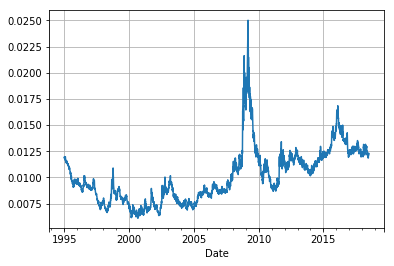

In [40]:
df_SP600[DIVIDEND_YIELD]["1995":].plot(grid=True)

In [41]:
df_SP600[DIVIDEND_YIELD]["1995":].describe()

count    8582.000000
mean        0.010073
std         0.002635
min         0.006130
25%         0.008078
50%         0.009411
75%         0.011777
max         0.025011
Name: Dividend Yield, dtype: float64

### S&P 600 - 1 Year Returns

The following plot shows the actual historical 1-year returns of the S&P 600 as blue dots. The solid black line shows the model's forecasted mean, which has a very poor fit to the historical returns.

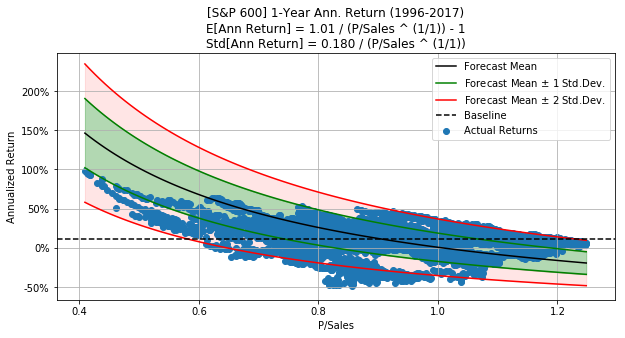

	Forecast	Baseline	p-value
MAE:	17.9%		14.1%		1.01e-116
R^2:	-0.46


In [42]:
plot_ann_returns(years=1, ticker=ticker_SP600, df=df_SP600)

### S&P 600 - 3 Year Returns

The following plot shows the historical 3-year returns of the S&P 600, which starts to fit the forecasting model, but the Goodness of Fit is fairly low at $R^2 = 0.24$ so most of the data's variance is still unexplained by the model.

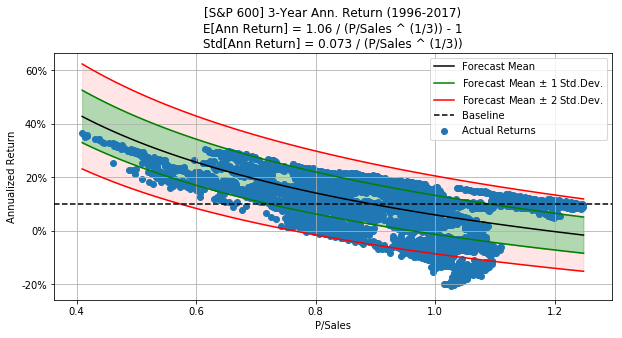

	Forecast	Baseline	p-value
MAE:	6.6%		6.9%		1.06e-09
R^2:	0.24


In [43]:
plot_ann_returns(years=3, ticker=ticker_SP600, df=df_SP600)

### S&P 600 - 5 Year Returns

The following plot shows the historical 5-year returns of the S&P 600. Just like the S&P 400 above, it fits the forecasting model reasonably well with exception of a cluster of outliers with P/Sales ratios around 0.95. Just as for the S&P 400, this is probably the 5-year period between 2004 and 2009, which ended in a stock-market crash.

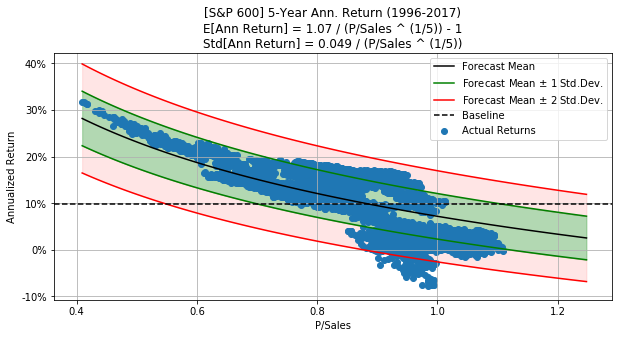

	Forecast	Baseline	p-value
MAE:	3.4%		5.3%		0.00e+00
R^2:	0.57


In [44]:
plot_ann_returns(years=5, ticker=ticker_SP600, df=df_SP600)

### S&P 600 - 3 to 7 Year Returns

We can again smoothen the effect of stock-market bubbles and crashes by considering the mean annualized return for e.g. 3-7 year investment periods. This is shown in the following plot which then fits the forecasting model fairly well with $R^2 = 0.65$.

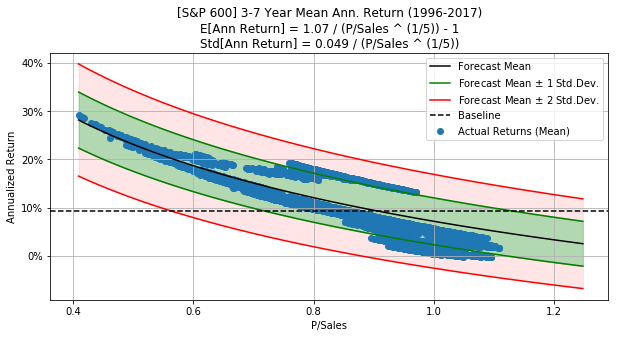

	Forecast	Baseline	p-value
MAE:	2.8%		4.4%		3.68e-302
R^2:	0.65


In [45]:
plot_ann_returns(years=5, years_range=2,
                 ticker=ticker_SP600, df=df_SP600)

### S&P 600 - 10 Year Returns

The following plot shows the S&P 600 for 10-year investment periods, which does not fit the forecasting model very well. The reason is unclear and would require more research.

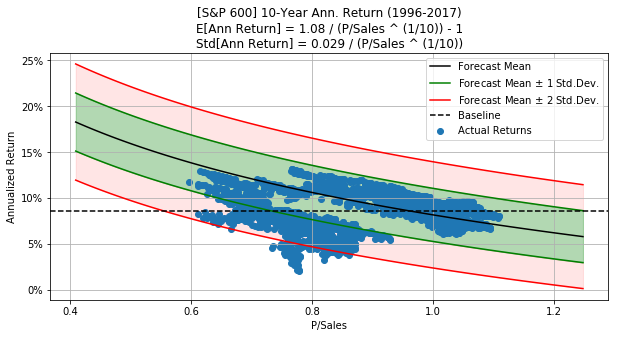

	Forecast	Baseline	p-value
MAE:	2.1%		1.5%		2.29e-105
R^2:	-0.94


In [46]:
plot_ann_returns(years=10, ticker=ticker_SP600, df=df_SP600)

## NASDAQ 100

The NASDAQ 100 index contains 100 of the largest non-financial stocks traded on the NASDAQ exchange (see [description](https://www.nasdaq.com/markets/indices/nasdaq-100.aspx)). We do not have data for the NASDAQ 100 index itself, so we use data for an Exchange Traded Fund (ETF) with the ticker symbol QQQ that tracks the NASDAQ 100 index.

### NASDAQ - Price and Total Return

The following plot compares the share-price and Total Return for the S&P 600 between 2002 and 2019, which is the same period for which we have the other financial data.

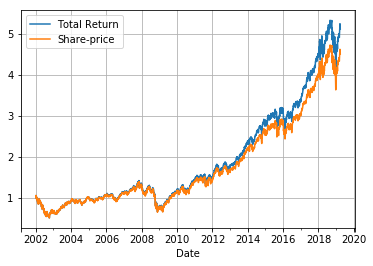

In [47]:
plot_price_total_return(df=df_QQQ["2002":])

### NASDAQ - P/Sales

The following plot and statistics show the historical P/Sales ratios for the NASDAQ 100 between 2002 and 2019. The P/Sales ratio was between 1.4 and 4.1 with a mean about 2.9.

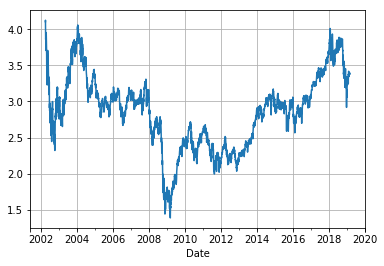

In [48]:
df_QQQ[PSALES].plot(grid=True)

In [49]:
df_QQQ[PSALES].describe()

count    6179.000000
mean        2.858183
std         0.509177
min         1.387867
25%         2.465714
50%         2.915132
75%         3.135186
max         4.124833
Name: P/Sales, dtype: float64

### NASDAQ - Sales Growth

The following plot and statistics show the historical annual growth in Sales Per Share for the NASDAQ 100, which was between -2% and +33% with a mean of about 11.4%.

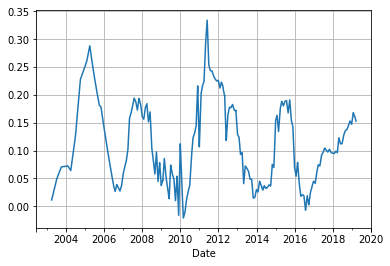

In [50]:
df_QQQ[SALES_GROWTH].plot(grid=True)

In [51]:
df_QQQ[SALES_GROWTH].describe()

count    5839.000000
mean        0.114218
std         0.074280
min        -0.020979
25%         0.050689
50%         0.098598
75%         0.173477
max         0.334211
Name: Sales Growth, dtype: float64

### NASDAQ - Dividend Yield

The following plot shows the historical dividend yield for the NASDAQ 100 between 2002 and 2019, which ranged between 0.0% and 2.1% with a mean of about 0.8%.

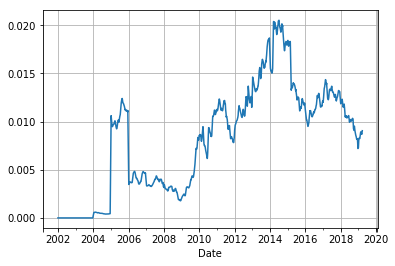

In [52]:
df_QQQ[DIVIDEND_YIELD]["2002":].plot(grid=True)

In [53]:
df_QQQ[DIVIDEND_YIELD]["2002":].describe()

count    6.293000e+03
mean     8.154579e-03
std      5.614934e-03
min     -2.566770e-07
25%      3.239253e-03
50%      9.365185e-03
75%      1.214337e-02
max      2.051265e-02
Name: Dividend Yield, dtype: float64

### NASDAQ - 1 Year Returns

This plot shows the actual historical 1-year returns of the NASDAQ 100 as blue dots. The solid black line shows the model's forecasted mean, which has a very poor fit to the historical returns.

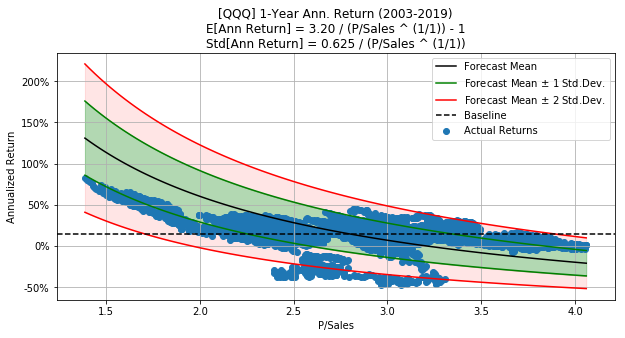

	Forecast	Baseline	p-value
MAE:	17.8%		13.0%		7.32e-196
R^2:	-0.60


In [54]:
plot_ann_returns(years=1, ticker=ticker_QQQ, df=df_QQQ)

### NASDAQ - 3 Year Returns

This plot shows the historical 3-year returns of the NASDAQ 100, which fits the forecasting model reasonably well with $R^2=0.41$ for such short investment periods.

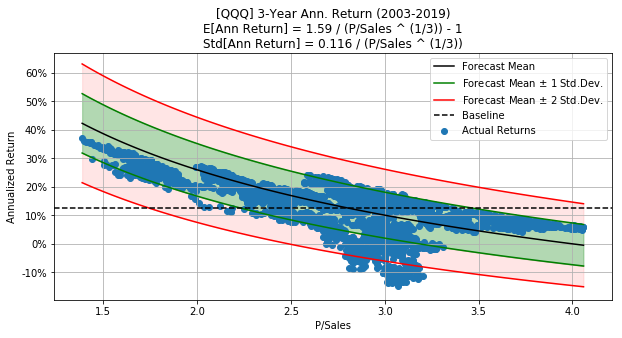

	Forecast	Baseline	p-value
MAE:	5.2%		7.2%		9.71e-216
R^2:	0.41


In [55]:
plot_ann_returns(years=3, ticker=ticker_QQQ, df=df_QQQ)

### NASDAQ - 5 Year Returns

The following plot shows the historical 5-year returns of the NASDAQ 100. The forecasting model fits quite well with $R^2 = 0.69$.

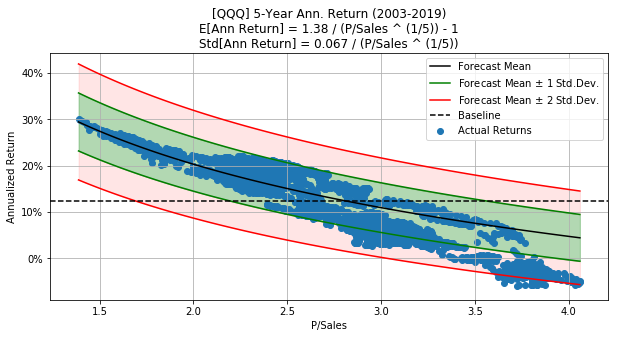

	Forecast	Baseline	p-value
MAE:	3.4%		6.7%		0.00e+00
R^2:	0.69


In [56]:
plot_ann_returns(years=5, ticker=ticker_QQQ, df=df_QQQ)

### NASDAQ - 10 Year Returns

The following plot shows the NASDAQ 100 for 10-year investment periods, which fits the forecasting model very well, with $R^2 = 0.82$ so most of the data's variance is explained by the forecasting model.

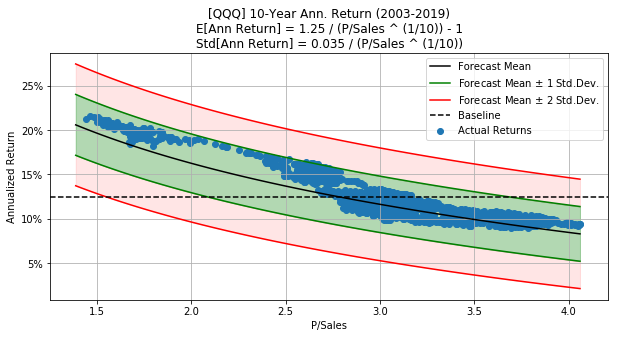

	Forecast	Baseline	p-value
MAE:	0.9%		1.8%		2.33e-141
R^2:	0.82


In [57]:
plot_ann_returns(years=10, ticker=ticker_QQQ, df=df_QQQ)

### NASDAQ - 3 to 7 Year Returns

We can again smoothen the effect of stock-market bubbles and crashes by considering the mean annualized return for e.g. 3-7 year investment periods. This is shown in the following plot which fits the forecasting model with $R^2 = 0.71$. This is only a slightly better fit than for fixed 5-year investment periods which was plotted above and had $R^2 = 0.69$.

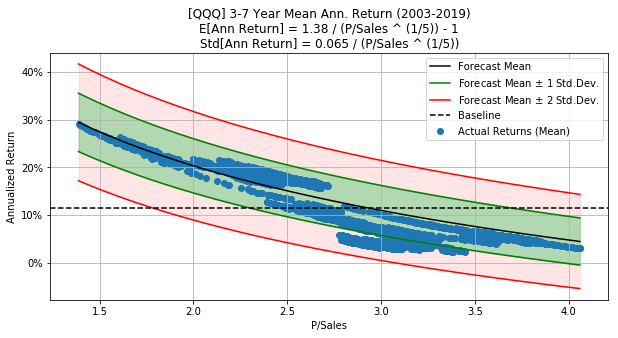

	Forecast	Baseline	p-value
MAE:	3.1%		6.3%		0.00e+00
R^2:	0.71


In [58]:
plot_ann_returns(years=5, years_range=2,
                 ticker=ticker_QQQ, df=df_QQQ)

## Correlation

We will now study the correlation of the P/Sales ratios of the stock indices. This is of interest because it tells us whether the stock indices tend to be cheap or expensive at the same time.

This is important if we want to construct an investment strategy that switches between these stock indices, so that it buys the cheap indices and sells the expensive indices.

Unfortunately, we will now see that these stock indices are highly correlated, so they tend to be cheap or expensive at the same time.

In [59]:
# Lists of tickers and data we want to compare.
tickers = [ticker_SP500, ticker_SP400, ticker_SP600, ticker_QQQ]
dfs = [df_SP500[PSALES], df_SP400[PSALES],
       df_SP600[PSALES], df_QQQ[PSALES]]

# Create a single DataFrame with all the P/Sales ratios.
df_psales = pd.concat(dfs, axis=1).dropna()

# Rename columns to ticker-symbols.
df_psales.set_axis(tickers, axis=1, inplace=True)

The following table shows the correlation of the P/Sales ratios for the stock indices. A value of 1 means complete positive correlation so that the P/Sales ratios of two indices are always high or low at the same time, a value of 0 means there is no correlation, a value of -1 means complete negative correlation.

The table shows that the P/Sales ratios of these stock indices are highly correlated. For example, the S&P 500 and S&P 400 have a correlation coefficient of 0.86 which means that these two indices almost always have high or low P/Sales ratios at the same time. The least correlated stock indices are S&P 600 and the QQQ ETF, whose correlation coefficient is 0.48, although this is still a substantial correlation.

In [60]:
df_psales.corr()

,S&P 500,S&P 400,S&P 600,QQQ
S&P 500,1.000000,0.861719,0.814126,0.702399
S&P 400,0.861719,1.000000,0.941318,0.631153
S&P 600,0.814126,0.941318,1.000000,0.483363
QQQ,0.702399,0.631153,0.483363,1.000000


We can also make a scatter-plot of the P/Sales ratios for the S&P 500 versus S&P 400, which clearly shows the strong correlation.

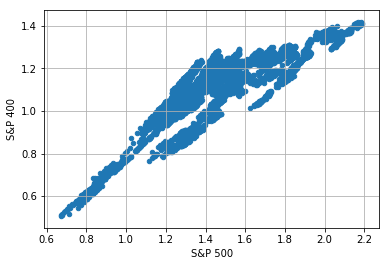

In [61]:
df_psales.plot(kind='scatter', x=ticker_SP500, y=ticker_SP400, grid=True)

The following scatter-plot shows the P/Sales ratios for the S&P 600 versus the QQQ ETF. This shows a strong correlation for low P/Sales ratios, so that both indices are cheap at the time of market-crashes. But for higher P/Sales ratios, the correlation is weaker. Overall the correlation coefficient is 0.48.

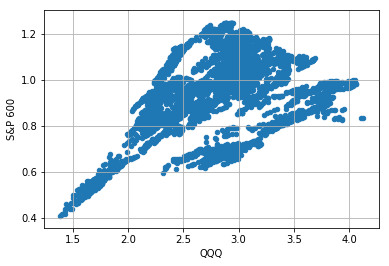

In [62]:
df_psales.plot(kind='scatter', x=ticker_QQQ, y=ticker_SP600, grid=True)

## Summary

We now summarize the forecasting formulas for easy reference.

### Historical Averages

The following table shows the average historical sales growth, dividend yield and P/Sales ratios used in the forecasting model. These are calculated for overlapping but not identical periods in time. For example, the S&P 500 data is for the period between 1988 and 2017, while the data for NASDAQ (QQQ) is for the period between 2002 and early 2019.

| &nbsp;         | S&P 500 | S&P 400 | S&P 600 | NASDAQ |
| --- | --- | --- | --- | --- |
| Sales Growth   | 3.7%    | 8.7%    | 8.3%    | 11.4%  |
| Dividend Yield | 2.1%    | 1.3%    | 1.0%    | 0.8%   |
| P/Sales        | 1.36    | 1.10    | 0.92    | 2.86   |

### Forecasting Formulas

The mathematical formulas used to forecast the mean annualized returns and their standard deviation are also reprinted here for easy reference:

$$
E[Ann\ Return_t] = \frac{a}{P/Sales_t ^ {1/Years}} - 1
$$

$$
Std[Ann\ Return_t] = \frac{b}{P/Sales_t ^ {1/Years}}
$$

### P/Sales Today

When using the forecasting formulas, we need to input today's P/Sales ratio. The following table shows the P/Sales ratios from April 9, 2019, with internet links where you can see the current data from corresponding ETFs on Morningstar.

| &nbsp;         | S&P 500 | S&P 400 | S&P 600 | NASDAQ |
| --- | --- | --- | --- | --- |
| P/Sales April 2019 | 1.97    | 1.15    | 0.91    | 3.27  |
| ETF Data | [VOO](http://portfolios.morningstar.com/fund/summary?t=VOO&region=usa&culture=en_US) | [IJH](http://portfolios.morningstar.com/fund/summary?t=IJH&region=usa&culture=en_US) | [IJR](http://portfolios.morningstar.com/fund/summary?t=IJR&region=usa&culture=en_US) | [QQQ](http://portfolios.morningstar.com/fund/summary?t=QQQ&region=usa&culture=en_US) |

Note that Morningstar reports the P/Sales ratios as *"forward-looking based on historical data"*. It is unclear what exactly is meant by this. It is also unclear if the P/Sales ratios are updated daily or only monthly. So they should only be considered an estimate.

### 3 to 7 Year Returns

The following table shows a summary of the parameters $a$ and $b$ used in the forecasting formulas for 3-7 year returns. Also shown is the $R^2$ measure of how well the historical data fits the forecasting model.

| &nbsp; | S&P 500 | S&P 400 | S&P 600 | NASDAQ |
| --- | --- | --- | --- | --- |
| $a$   | 1.12  | 1.12  | 1.07  | 1.38  |
| $b$   | 0.073 | 0.045 | 0.048 | 0.066 |
| $R^2$ | 0.68  | 0.60  | 0.65  | 0.71  |

For example, we can use the forecasting formula for NASDAQ (QQQ) with the above parameters $a$ and $b$, and the P/Sales ratio of 3.27 from early April 2019, as follows:

$$
E[Ann\ Return_t] = \frac{a}{P/Sales_t ^ {1/Years}} - 1 = \frac{1.38}{3.27 ^ {1/5}} - 1 \simeq 8.9\%
$$

$$
Std[Ann\ Return_t] = \frac{b}{P/Sales_t ^ {1/Years}} = \frac{0.066}{3.27 ^ {1/5}} \simeq 5.2\%
$$

This means that the QQQ ETF is expected to have an annualized return of about 8.9% with a standard deviation of 5.2% for 3-7 year investment periods. Note that we used the average period length $Years=5$ in the forecasting model for 3-7 year periods.

The following table shows the forecasted annualized return for all these stock indices for 3-7 year periods, using the P/Sales ratios from early April 2019.

| &nbsp;         | S&P 500 | S&P 400 | S&P 600 | NASDAQ |
| --- | --- | --- | --- | --- |
| P/Sales April 2019 | 1.97 | 1.15 | 0.91 | 3.27 |
| Forecasted Return Mean | -2.2% | 8.9% | 9.0% | 8.9% |
| Forecasted Return Std | 6.4% | 4.4% | 4.8% | 6.6% |

The S&P 500 is expected to have an annualized loss of -2.2%, while the other indices have roughly the same forecasted gain of about 9%. The S&P 400 has the least uncertainty with a standard deviation of 4.4% while NASDAQ (QQQ) has the greatest uncertainty with a std.dev. of 6.6%.

The forecasted loss of -2.2% for the S&P 500 mainly comes from a revaluation because the current P/Sales ratio is 1.97 while the average historical P/Sales ratio was only 1.36, which results in a revaluation loss of about -30%, or about -7.1% per year. The sales growth is assumed to be equal to the historical average of 3.7% per year and the dividend yield is assumed to contribute another 2.1% return per year. So the revaluation causes a much greater annualized loss than the sales growth and dividend yield can make up for. (Note that the forecasting model doesn't calculate this by a simple sum, so these numbers do not add up to the forecasted loss of -2.2%.)

Now consider NASDAQ whose current P/Sales ratio is 3.27 which is about 15% higher than its historical average of 2.86, so the forecasting model expects an annualized loss of about -2.6% from revaluation of the P/Sales ratio back to its historical average, while the sales growth is assumed to be its historical average of 11.4%, which is about 3 percentage points higher than for the S&P 400 and 600. So the forecasted return of 8.9% for NASDAQ includes a small loss from revaluation, a large gain from sales growth, and less than 1% gain from dividends.

Compare this to the S&P 400 and 600 which are trading roughly at their historical average P/Sales ratios, so their future returns are expected to come mostly from the 8-9% sales growth and roughly 1% dividend yields.

### 10 Year Returns

The following table shows the parameters for the forecasting model when used for 10-year investment periods. The table also shows the $R^2$ values for how well the forecasting model fits the historical data. The forecasting model does not fit the historical data for the S&P 400 and 600 indices very well, as shown by the negative $R^2$ values, but we will try and calculate their forecasted returns using these parameters anyway.

| &nbsp; | S&P 500 | S&P 400 | S&P 600 | NASDAQ |
| --- | --- | --- | --- | --- |
| $a$   | 1.09  | 1.11  | 1.08  | 1.25  |
| $b$   | 0.038 | 0.027 | 0.028 | 0.035 |
| $R^2$ | 0.75  | -0.26 | -0.94 | 0.82  |

For NASDAQ (QQQ) the forecasted return for the 10 years between April 2019 and 2029, is found by using the forecasting formula with the above parameters $a$ and $b$ and the P/Sales ratio of 3.27 for April 2019. The result is a forecasted mean return of 11.0% per year with a standard deviation of 3.1%:

$$
E[Ann\ Return_t] = \frac{a}{P/Sales_t ^ {1/Years}} - 1 = \frac{1.25}{3.27 ^ {1/10}} - 1 \simeq 11.0\%
$$

$$
Std[Ann\ Return_t] = \frac{b}{P/Sales_t ^ {1/Years}} = \frac{0.035}{3.27 ^ {1/10}} \simeq 3.1\%
$$

The following table shows the forecasted returns for all four stock indices for the 10-year period between April 2019 and 2029.

| &nbsp;         | S&P 500 | S&P 400 | S&P 600 | NASDAQ |
| --- | --- | --- | --- | --- |
| P/Sales April 2019 | 1.97 | 1.15 | 0.91 | 3.27 |
| Forecasted Return Mean | 1.8% | 9.5% | 9.0% | 11.0% |
| Forecasted Return Std  | 3.6% | 2.7% | 2.8% | 3.1% |

The lowest forecasted return is 1.8% per year for the S&P 500. The highest forecasted return is 11.0% for the NASDAQ 100. Interestingly, the standard deviation is slightly lower for NASDAQ at 3.1% compared to 3.6% for the S&P 500, even though NASDAQ has a much higher forecasted mean. It is important to understand that the standard deviation does *not* measure "investment risk", it measures the spread of possible outcomes, or the degree of uncertainty around the mean forecast.

The S&P 500 is currently trading at a significantly higher P/Sales ratio than its historical average, so the forecasting model assumes there will be a loss from a future revaluation back to the historical average. The current P/Sales ratio is 1.97 and the historical average is 1.36, so the loss is expected to be about $1.36/1.97 - 1 \simeq - 31\%$. Spreading this over 10 years gives an annualized loss of about -3.6% from the revaluation. This is offset by assuming the historical average sales growth and dividend yield will continue in the future, giving a gain of 3.7% and 2.1% respectively. Note that these numbers don't simply add up to the forecasted return of 1.8% because the forecasting formula is a bit more complicated.

Although the historical data for the S&P 400 and 600 fit the forecasting model very poorly, it was unclear what caused this. Lacking a better model, it might still be useful to consider the forecasted returns of the S&P 400 and 600 as rough estimates. The forecasted return for the S&P 400 is 9.5% per year, and it is 9.0% for the S&P 600. For the NASDAQ 100 the forecasted return is 11.0%. All of these forecasts assume that future sales growth, dividend yield, and P/Sales ratios will be similar to the historical averages.

## Discussion

### P/E vs. P/Sales

As discussed in several of the previous papers, we use the P/Sales ratio instead of the P/E ratio because it is more stable.

The P/Sales ratio is defined as the Price Per Share divided by the Sales Per Share. This is used as a gauge of how cheap or expensive the shares are relative to the past 12 months of sales per share. The problem is that P/Sales ratios are hard to interpret and compare because a "fair" P/Sales ratio differs between companies.

The P/E ratio is defined as the Price Per Share divided by the Earnings Per Share. This is easier to interpret, especially if we consider the reciprocal Earnings Yield, because that can be given as a percentage and compared amongst companies, and even compared to bond yields. The problem is that the Earnings Per Share number may fluctuate greatly and it can also be zero or even negative, which means that the P/E ratio is no longer well-defined. This creates more noisy data and sometimes makes it impossible to use the current P/E ratio as the predictor variable in the forecasting formula.


### Adjusting Growth-Rates

A nice feature of using these forecasting formulas, is that we can easily adjust the assumptions. For example, if we believe the future sales growth will be 2% higher than the historical average used when calculating the formula's parameter $a$, we simply adjust $a$ by scaling it with 1.02.

However, a significant part of the forecasted return may come from revaluation of the P/Sales ratio. So if the future P/Sales ratios will have a different mean value from the historical data, then we would need to adjust the parameter $a$ accordingly. But it is currently not clear what determines a "fair" P/Sales ratio, so changing it from its past would just be a guess. More research is needed to understand how P/Sales ratios are typically related to e.g. sales growth and profit margins.


### Portfolio Optimization

We could develop a simple strategy that invests in a portfolio of ETFs for the different stock-market indices depending on their forecasted returns. This requires two things: 

1) In order to use the forecasting model to estimate the future returns, we must first estimate the future means for the dividend yield, sales growth, and P/Sales ratios. A simple solution is to use the historical data and assume the future means are roughly similar. This may be a reasonable assumption for broadly diversified stock indicies.

2) In order for the strategy to switch the investment portfolio from one stock index into another, the indices must have low or inverse correlation. Unfortunately these four stock indices for USA are highly correlated, so they are usually cheap or expensive at the same time, which means the strategy cannot switch between them, by selling an expensive index and buying a cheap index. We need stock indices that have low or negative correlation for this to work.

## Conclusion

This paper applied our method for long-term stock forecasting from a [previous paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/01C_Theory_of_Long-Term_Stock_Forecasting.ipynb) to four stock indices for USA: S&P 500 (Large-Cap), S&P 400 (Mid-Cap), S&P 600 (Small-Cap), and NASDAQ-100 (mainly technology).

The forecasting model worked quite well on the historical data with a few exceptions. Whether it will work in the future, depends on how accurately we can estimate the future averages for the dividend yield, sales growth and P/Sales ratios for the stock indices.

Because of the broad diversification of these stock indices, and the somewhat cyclical and mean-reverting nature of the historical data, it seems fair to assume that the historical averages are reasonable estimates for the future.

This means we can use the presented formulas to estimate the long-term future returns of these four stock indices.

## Research Ideas

You are strongly encouraged to do more research on this topic. If you make any new discoveries then please let me know your results. 

To my knowledge, there are no academic studies of predicting the long-term returns of stocks and stock-markets as we have done here. A lot more research can be done on this subject and it may impact many areas of both theoretical and applied finance.

Here are a few more research ideas to get you started:

- Scrutinize the mathematics and Python implementation to try and find errors.

- If you have access to financial data for other indices, try and use it with the forecasting model. Does it work? Why not?

- Why do the 10-year returns for the S&P 400 and 600 fit the forecasting model so poorly, yet the 3-7 returns fit quite well?

- Can you find a better way of estimating the future mean dividend yield, sales growth, and P/Sales ratios?

- How is the P/Sales ratio determined for different stocks and indices? Is it related to the profit margin and sales growth?

- If you had more stock indices with low correlation, how would you do portfolio optimization?

## License (MIT)

Copyright (c) 2018-2019 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.